In [1]:
!pip install --upgrade jupyter notebook ipywidgets

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv('C:/Users/mahas/rogueshield-ai-threat-detector/data/UNSW_NB15_training-set.csv')

df.head()


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
# Add timestamp for simulation
df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='T')
df.set_index('timestamp', inplace=True)

#Resample attack volumes per day
daily_attacks = df[df['label'] == 1].resample('D').size().rename("attack_count").to_frame()

# Prepare for Prophet
attack_volume = daily_attacks.reset_index().rename(columns={'timestamp': 'ds', 'attack_count': 'y'})

C:\Users\mahas\AppData\Local\Temp\ipykernel_16224\1082200642.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['timestamp'] = pd.date_range(start='2025-01-01', periods=len(df), freq='T')


In [5]:
print(attack_volume.dtypes)
print(attack_volume.head())

ds    datetime64[ns]
y              int64
dtype: object
          ds     y
0 2025-01-01  1197
1 2025-01-02  1440
2 2025-01-03  1440
3 2025-01-04  1440
4 2025-01-05  1440


In [6]:
from prophet import Prophet

model = Prophet()
model.fit(attack_volume)

23:46:19 - cmdstanpy - INFO - Chain [1] start processing
23:46:19 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Forecast 14 days into the future
future = model.make_future_dataframe(periods=14)
forecast = model.predict(future)


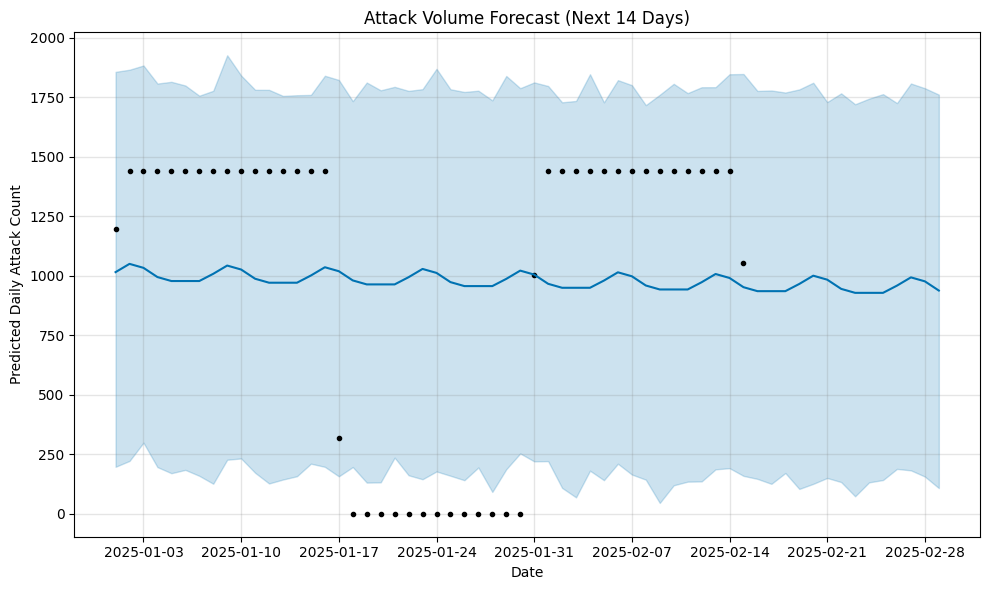

In [8]:
import matplotlib.pyplot as plt

fig = model.plot(forecast)
plt.title("Attack Volume Forecast (Next 14 Days)")
plt.xlabel("Date")
plt.ylabel("Predicted Daily Attack Count")
plt.grid(True)
plt.tight_layout()
plt.savefig("forecast.png")  # This saves the plot to your local directory
plt.show()

In [9]:
from prophet.diagnostics import cross_validation, performance_metrics

In [10]:
# Try a short enough window for your data (adjust if needed)
df_cv = cross_validation(
    model, 
    initial='21 days',     # Initial training period
    period='7 days',       # Spacing between cutoff points
    horizon='7 days'       # Forecast window
)


  0%|          | 0/3 [00:00<?, ?it/s]

23:46:19 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing
23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing
23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing


In [11]:
df_p = performance_metrics(df_cv)
df_p[['horizon', 'rmse', 'mae', 'smape', 'coverage']].head()

,horizon,rmse,mae,smape,coverage
0,1 days,1083.991728,881.192524,1.629517,0.333333
1,2 days,1084.007121,881.209476,1.629539,0.333333
2,3 days,1084.022519,881.226504,1.629560,0.333333
3,4 days,1142.061120,979.113399,1.627501,0.333333
4,5 days,1101.777847,929.153292,1.608400,0.333333


In [12]:
print("Attack Volume Forecast Evaluation Metrics:")
print(df_p[['horizon', 'rmse', 'mae', 'smape', 'coverage']].describe())

Attack Volume Forecast Evaluation Metrics:
                         horizon         rmse          mae     smape  coverage
count                          7     7.000000     7.000000  7.000000  7.000000
mean             4 days 00:00:00  1210.595585  1046.129416  1.608350  0.285714
std    2 days 03:50:45.332114146   195.541728   234.710593  0.041336  0.125988
min              1 days 00:00:00  1083.991728   881.192524  1.516404  0.000000
25%              2 days 12:00:00  1084.014820   881.217990  1.612965  0.333333
50%              4 days 00:00:00  1101.777847   929.153292  1.627501  0.333333
75%              5 days 12:00:00  1280.935695  1175.132846  1.629528  0.333333
max              7 days 00:00:00  1558.498488  1399.858422  1.629560  0.333333


c:\Users\mahas\anaconda3\envs\rogueshield\lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\mahas\anaconda3\envs\rogueshield\lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


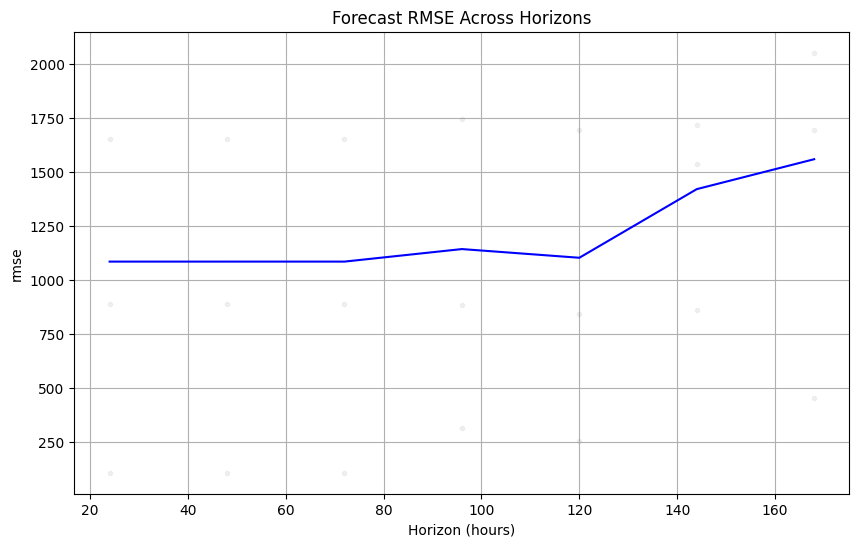

c:\Users\mahas\anaconda3\envs\rogueshield\lib\site-packages\prophet\plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
c:\Users\mahas\anaconda3\envs\rogueshield\lib\site-packages\prophet\plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


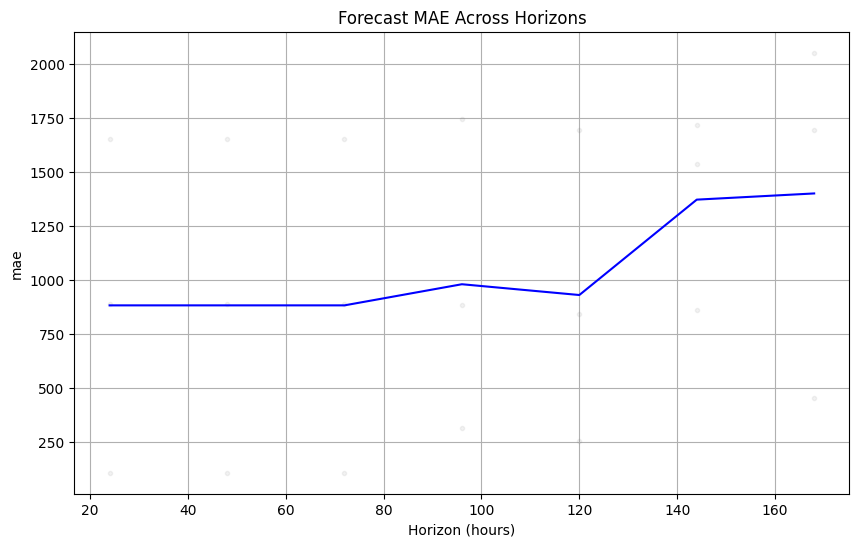

In [13]:
from prophet.plot import plot_cross_validation_metric

# Visualize RMSE over different horizons
plot_cross_validation_metric(df_cv, metric='rmse')
plt.title("Forecast RMSE Across Horizons")
plt.grid(True)
plt.show()

# Visualize MAE over different horizons
plot_cross_validation_metric(df_cv, metric='mae')
plt.title("Forecast MAE Across Horizons")
plt.grid(True)
plt.show()

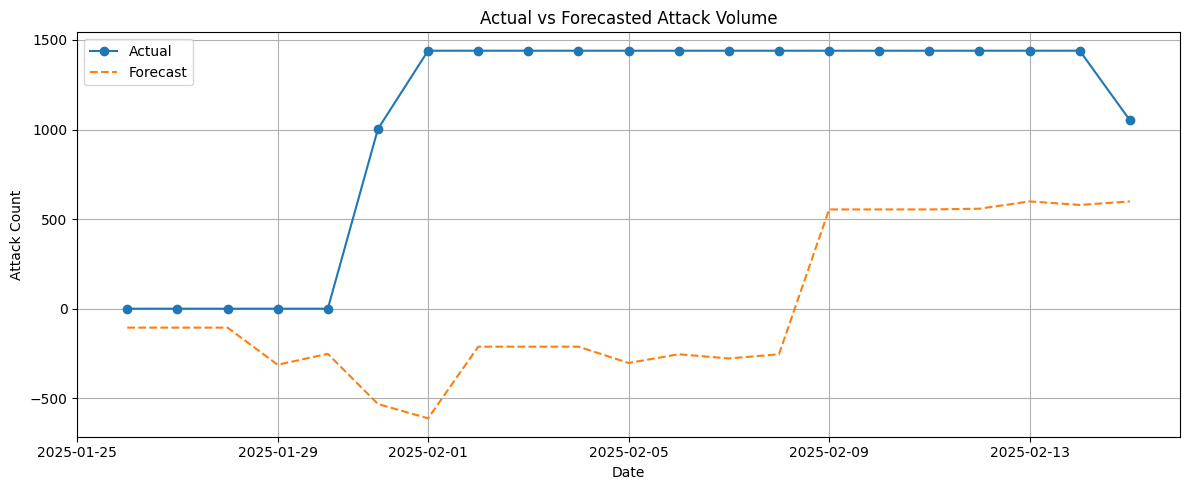

In [16]:
# Merge actual and predicted values
merge_df = df_cv[['ds', 'yhat', 'y']]

# Plot actual vs predicted
plt.figure(figsize=(12, 5))
plt.plot(merge_df['ds'], merge_df['y'], label='Actual', marker='o')
plt.plot(merge_df['ds'], merge_df['yhat'], label='Forecast', linestyle='--')
plt.title("Actual vs Forecasted Attack Volume")
plt.xlabel("Date")
plt.ylabel("Attack Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("actual_vs_forecast.png")
plt.show()
